# **Combined Data Cleaning, Feature Selection, Modeling and Interpretability into one report**

### Abstract:
The objective of this report is to meticulously clean and preprocess a dataset comprising the top 1000 IMDb movies, followed by an exploration of feature importance. Through rigorous analysis, key features contributing significantly to the movies' rankings will be identified. Subsequently, various predictive models will be deployed on these discerned features, facilitating a comprehensive assessment of model performance and robustness. Moreover, employing sophisticated model interpretability methods, such as SHAP (SHapley Additive exPlanations) or Partial Dependence Plots, will shed light on the intricate relationships between predictors and outcomes, enhancing our understanding of the underlying mechanisms driving movie ratings. This holistic approach aims to provide valuable insights into the factors influencing movie success, aiding in informed decision-making processes within the entertainment industry.


# We begin by cleaning the data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
import io

In [ ]:
# loading csv file onto colab
from google.colab import files
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['imdb_top_1000.csv']))


Saving imdb_top_1000.csv to imdb_top_1000.csv


In [ ]:
#Seeing how the data looks
data.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


 ### Lets have a look at the data types present
- **Poster_Link:** Categorical data (text/URL representing the poster link).
- **Series_Title:** Categorical data (text representing the title of the series/movie).
- **Released_Year:** Numeric data (representing the release year).
- **Certificate:** Categorical data (text representing the certification).
- **Runtime:** Categorical data (text representing the duration).
- **Genre:** Categorical data (text representing the genre).
- **IMDB_Rating:** Numeric data (representing the IMDb rating).
- **Overview:** Categorical data (text providing a brief overview or description).
- **Meta_score:** Numeric data (representing the metascore).
- **Director:** Categorical data (text representing the director's name).
- **Star1, Star2, Star3, Star4:** Categorical data (text representing the names of stars).
- **No_of_Votes:** Numeric data (representing the number of votes).
- **Gross:** Numeric data (representing the gross earnings).


In [ ]:
#Dropping columns with data that's not needed or columns with too many categories
columns_to_drop = ['Poster_Link','Series_Title', 'Overview', 'Director', 'Star1', 'Star2','Star3', 'Star4']
data = data.drop(columns=columns_to_drop)

###Lets fill the missing values

In [ ]:
#Check for all missing values
data.isna().sum()

Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Meta_score       157
No_of_Votes        0
Gross            169
dtype: int64

#### Certificate Column

In [ ]:
data['Certificate'].value_counts()

U           234
A           197
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
Unrated       1
U/A           1
Name: Certificate, dtype: int64


**Considering that movie certificates may not always be strictly enforced, and there can be variations in age restrictions across regions, I've decided to remove the 'Certificate' column from the dataset. This is because the certificate rating alone may not accurately reflect whether children or teenagers have watched a particular movie. The removal of this column will help streamline the dataset and avoid potential inaccuracies associated with certificate-based age restrictions.**

In [ ]:
data = data.drop('Certificate', axis=1)


In [ ]:
#Lets work with MetaScore, First lets see the occuring values and find their mean
print (data['Meta_score'].mean())
data['Meta_score'].fillna(data['Meta_score'].mean(), inplace=True)

#Now to full the impute values for Gross column with mean value
data.isna().sum()
data['Gross'] = data['Gross'].str.replace(',','').astype(float)
print (data['Gross'].mean())
data['Gross'] = data['Gross'].fillna(data['Gross'].mean())

# Assuming 'data' is your DataFrame
rows_with_nan = data[data.isnull().any(axis=1)]

# Print rows with NaN values
print("Rows with NaN values:")
print(rows_with_nan)

77.97153024911032
68034750.87364621
Rows with NaN values:
Empty DataFrame
Columns: [Released_Year, Runtime, Genre, IMDB_Rating, Meta_score, No_of_Votes, Gross]
Index: []


### Gross and Meta_Score do not have any Missing values now. Let's work with Genre, Released Year and Run Time

To Visualize Categorical variables such as Genre, I will be converting them to binary format.
- I will consider only 2 genres, Fiction and NonFiction for my purpose.
- Fiction: Drama, Comedy, Crime, Adventure, Action, Thriller, Romance, Mystery, Animation, Sci-Fi, Fantasy, Horror, Western, Film-Noir, Sport.
- Non-Fiction: Biography, History, Family, War, Music, Musical.
- I will only take the first genre string value into consideration for this, as based on observation, the first genre is the primary genre of the movie.

In [ ]:
# Define a function to classify genres
def classify_genre(genre):
    fiction_genres = ['Drama', 'Comedy', 'Crime', 'Adventure', 'Action', 'Thriller', 'Romance', 'Mystery', 'Animation', 'Sci-Fi', 'Fantasy', 'Horror', 'Western', 'Film-Noir', 'Sport']
    non_fiction_genres = ['Biography', 'History', 'Family', 'War', 'Music', 'Musical']

    first_genre = genre.split(', ')[0]  # Extract the first genre from the list

    if first_genre in fiction_genres:
        return 1  # Fiction
    elif first_genre in non_fiction_genres:
        return 0  # Non-Fiction
    else:
        return -1  # Unknown or other

# Apply the classification function to create the 'isFiction' column in the original DataFrame 'data'
data['isFiction'] = data['Genre'].apply(classify_genre)

# Display the modified DataFrame (data)
data.head()

#Dropping Genre column
data = data.drop('Genre', axis=1)

Seems like there is one row with a wrong value for year, row 966, I will fill it with the year based on movie released year.

In [ ]:
# Get the contents of row 966 using iloc
row_966 = data.iloc[966]

# Display the contents of row 966
print(row_966)

Released_Year             PG
Runtime              140 min
IMDB_Rating              7.6
Meta_score              77.0
No_of_Votes           269197
Gross            173837933.0
isFiction                  1
Name: 966, dtype: object


In [ ]:
data.at[966, 'Released_Year'] = ''
data['Released_Year'].dtype
column_name = 'Released_Year'

# Convert the column to numeric, coercing errors to replace non-convertible values with NaN
data[column_name] = pd.to_numeric(data[column_name], errors='coerce')

# Replace NaN values with 0
data[column_name] = data[column_name].fillna(0)

# Convert the column to int
data[column_name] = data[column_name].astype(int)

In [ ]:
data.at[966, 'Released_Year'] = 1995
print(data.iloc[966])

Released_Year           1995
Runtime              140 min
IMDB_Rating              7.6
Meta_score              77.0
No_of_Votes           269197
Gross            173837933.0
isFiction                  1
Name: 966, dtype: object


### Now let's work with Runtime

In [ ]:
#removing text from runtime column and converting it into int format
data['Runtime'] = data['Runtime'].str.replace('min', '').astype(int)
data = data.rename(columns={'Runtime': 'Runtime_in_mins'})

Minimum Runtime: 45 mins
Maximum Runtime: 321 mins
Range of Runtime: 276 mins


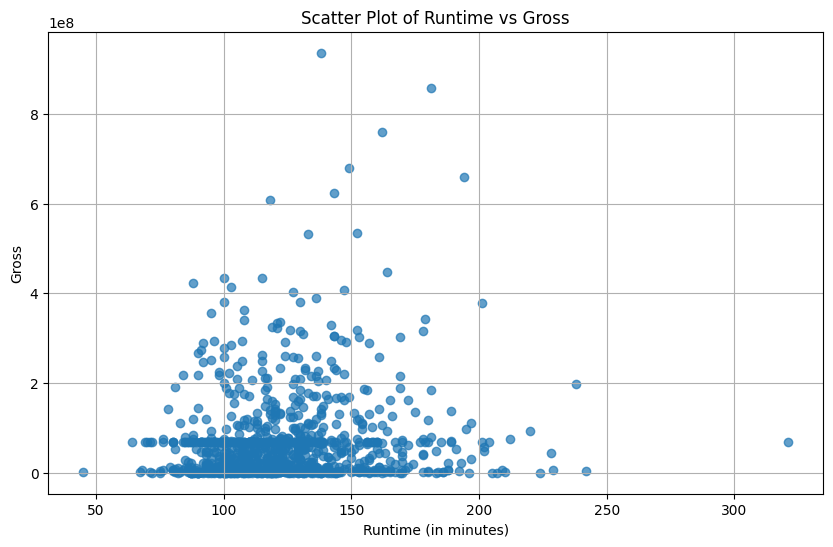

In [ ]:
# Calculate the minimum and maximum values of the 'Runtime_in_mins' column
min_runtime = data['Runtime_in_mins'].min()
max_runtime = data['Runtime_in_mins'].max()

# Calculate the range
range_runtime = max_runtime - min_runtime

print(f"Minimum Runtime: {min_runtime} mins")
print(f"Maximum Runtime: {max_runtime} mins")
print(f"Range of Runtime: {range_runtime} mins")

# Plotting a line graph between runtime and gross
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['Runtime_in_mins'], data['Gross'], alpha=0.7)
plt.xlabel('Runtime (in minutes)')
plt.ylabel('Gross')
plt.title('Scatter Plot of Runtime vs Gross')
plt.grid(True)
plt.show()

Based on the scatter plot, its hard to figure out any relation between gross value and runtime and since the values of runtime can vary between movies. I can also observe that before 90 mins and after 150 mins, the number of dots have decreased quite a lot ,so, I will categorise them into 3 parts. ( in mins)
- Short movie : Run time < 90
- Average movie: Run time > 90 && < 150
- Long movie: Run time > 150

In [ ]:
# Create the new columns with default values of 0
data['isShortRuntime'] = 0
data['isAvgRuntime'] = 0
data['isLongRuntime'] = 0

# Set values based on conditions
data.loc[data['Runtime_in_mins'] < 90, 'isShortRuntime'] = 1
data.loc[(data['Runtime_in_mins'] >= 90) & (data['Runtime_in_mins'] <= 150), 'isAvgRuntime'] = 1
data.loc[data['Runtime_in_mins'] > 150, 'isLongRuntime'] = 1

#dropping Runtime_in_mins column
data = data.drop('Runtime_in_mins', axis=1)

# Display the modified DataFrame
data.head()

,Released_Year,IMDB_Rating,Meta_score,No_of_Votes,Gross,isFiction,isShortRuntime,isAvgRuntime,isLongRuntime
0,1994,9.3,80.0,2343110,28341469.0,1,0,1,0
1,1972,9.2,100.0,1620367,134966411.0,1,0,0,1
2,2008,9.0,84.0,2303232,534858444.0,1,0,0,1
3,1974,9.0,90.0,1129952,57300000.0,1,0,0,1
4,1957,9.0,96.0,689845,4360000.0,1,0,1,0


### Let's normalize the data to be on par with range of Meta_Score for better visualisation


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object with the custom range (1 to 10)
custom_scaler = MinMaxScaler(feature_range=(1, 10))

# Normalize the specified columns in the original 'data' DataFrame
columns_to_normalize = ['No_of_Votes', 'Gross', 'Meta_score']
data[columns_to_normalize] = custom_scaler.fit_transform(data[columns_to_normalize])
data.head()

,Released_Year,IMDB_Rating,Meta_score,No_of_Votes,Gross,isFiction,isShortRuntime,isAvgRuntime,isLongRuntime
0,1994,9.3,7.50,10.000000,1.272309,1,0,1,0
1,1972,9.2,10.00,7.193863,2.296826,1,0,0,1
2,2008,9.0,8.00,9.845169,6.139228,1,0,0,1
3,1974,9.0,8.75,5.289768,1.550560,1,0,0,1
4,1957,9.0,9.50,3.580999,1.041881,1,0,1,0


## Data Cleaning Completed

---

## Exploratory Data Analysis

1. Let's check how each feature is correlated using a Heatmap to show the results of a **Correlation Matrix**

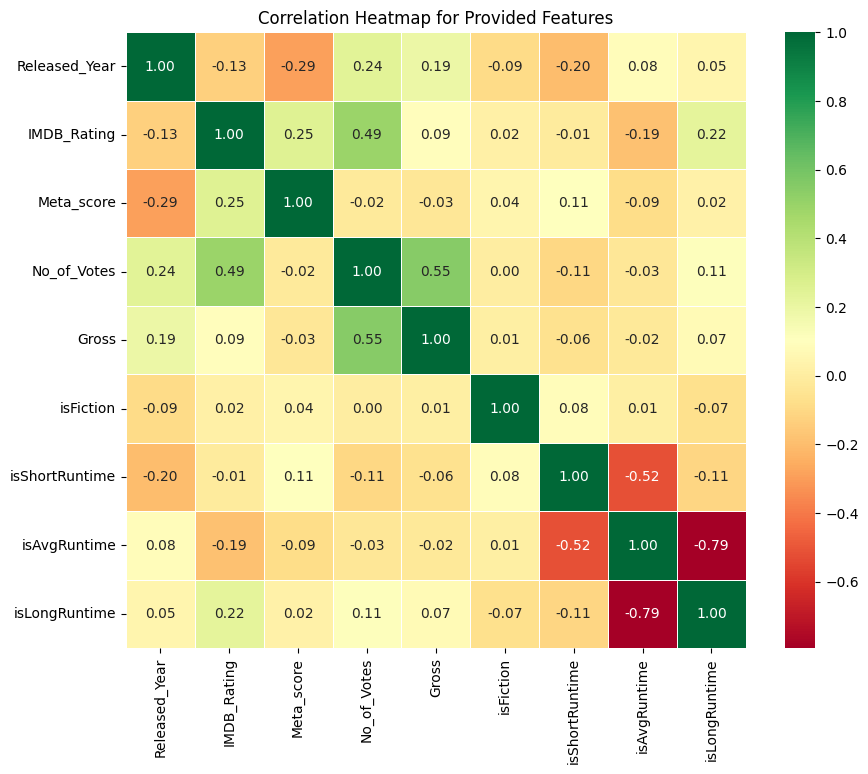

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn", fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap for Provided Features')
plt.show()

### Based of the results of the Heatmap,
- I can see that No_of_Votes and the target variable Gross has the highest positive correlation with a value of 0.57
- Followed by No_of_Votes and IMDB rating with a value of 0.49


2. Bar Plots

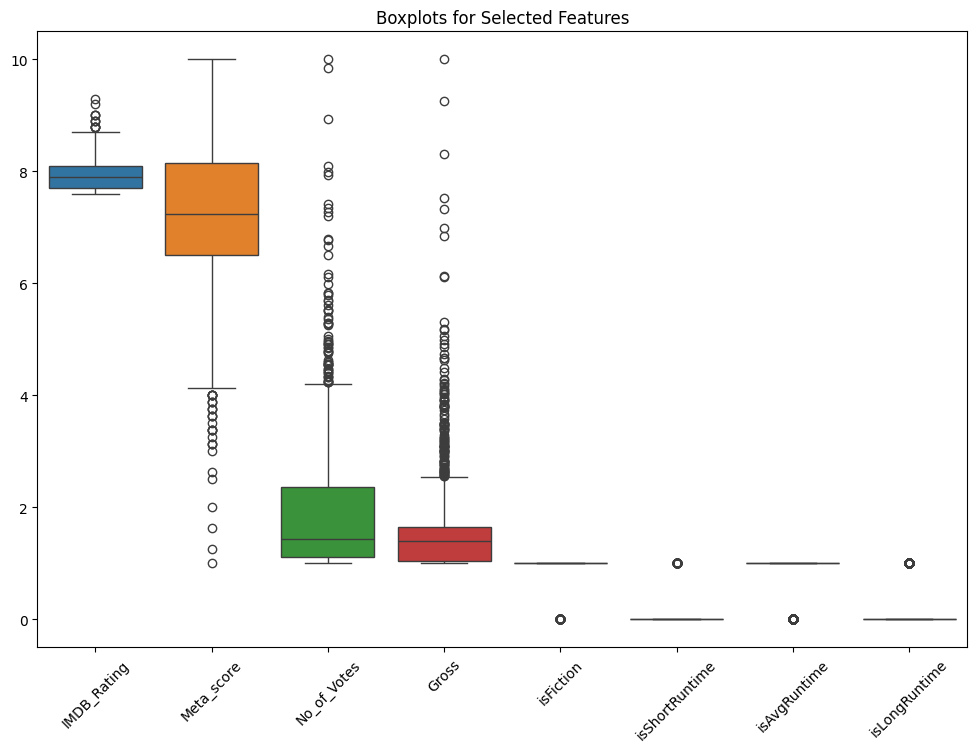

In [ ]:
features_to_plot = ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross', 'isFiction', 'isShortRuntime', 'isAvgRuntime', 'isLongRuntime']

# Create a boxplot for each feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[features_to_plot])
plt.xticks(rotation=45)
plt.title('Boxplots for Selected Features')
plt.show()

3. Pair Plots

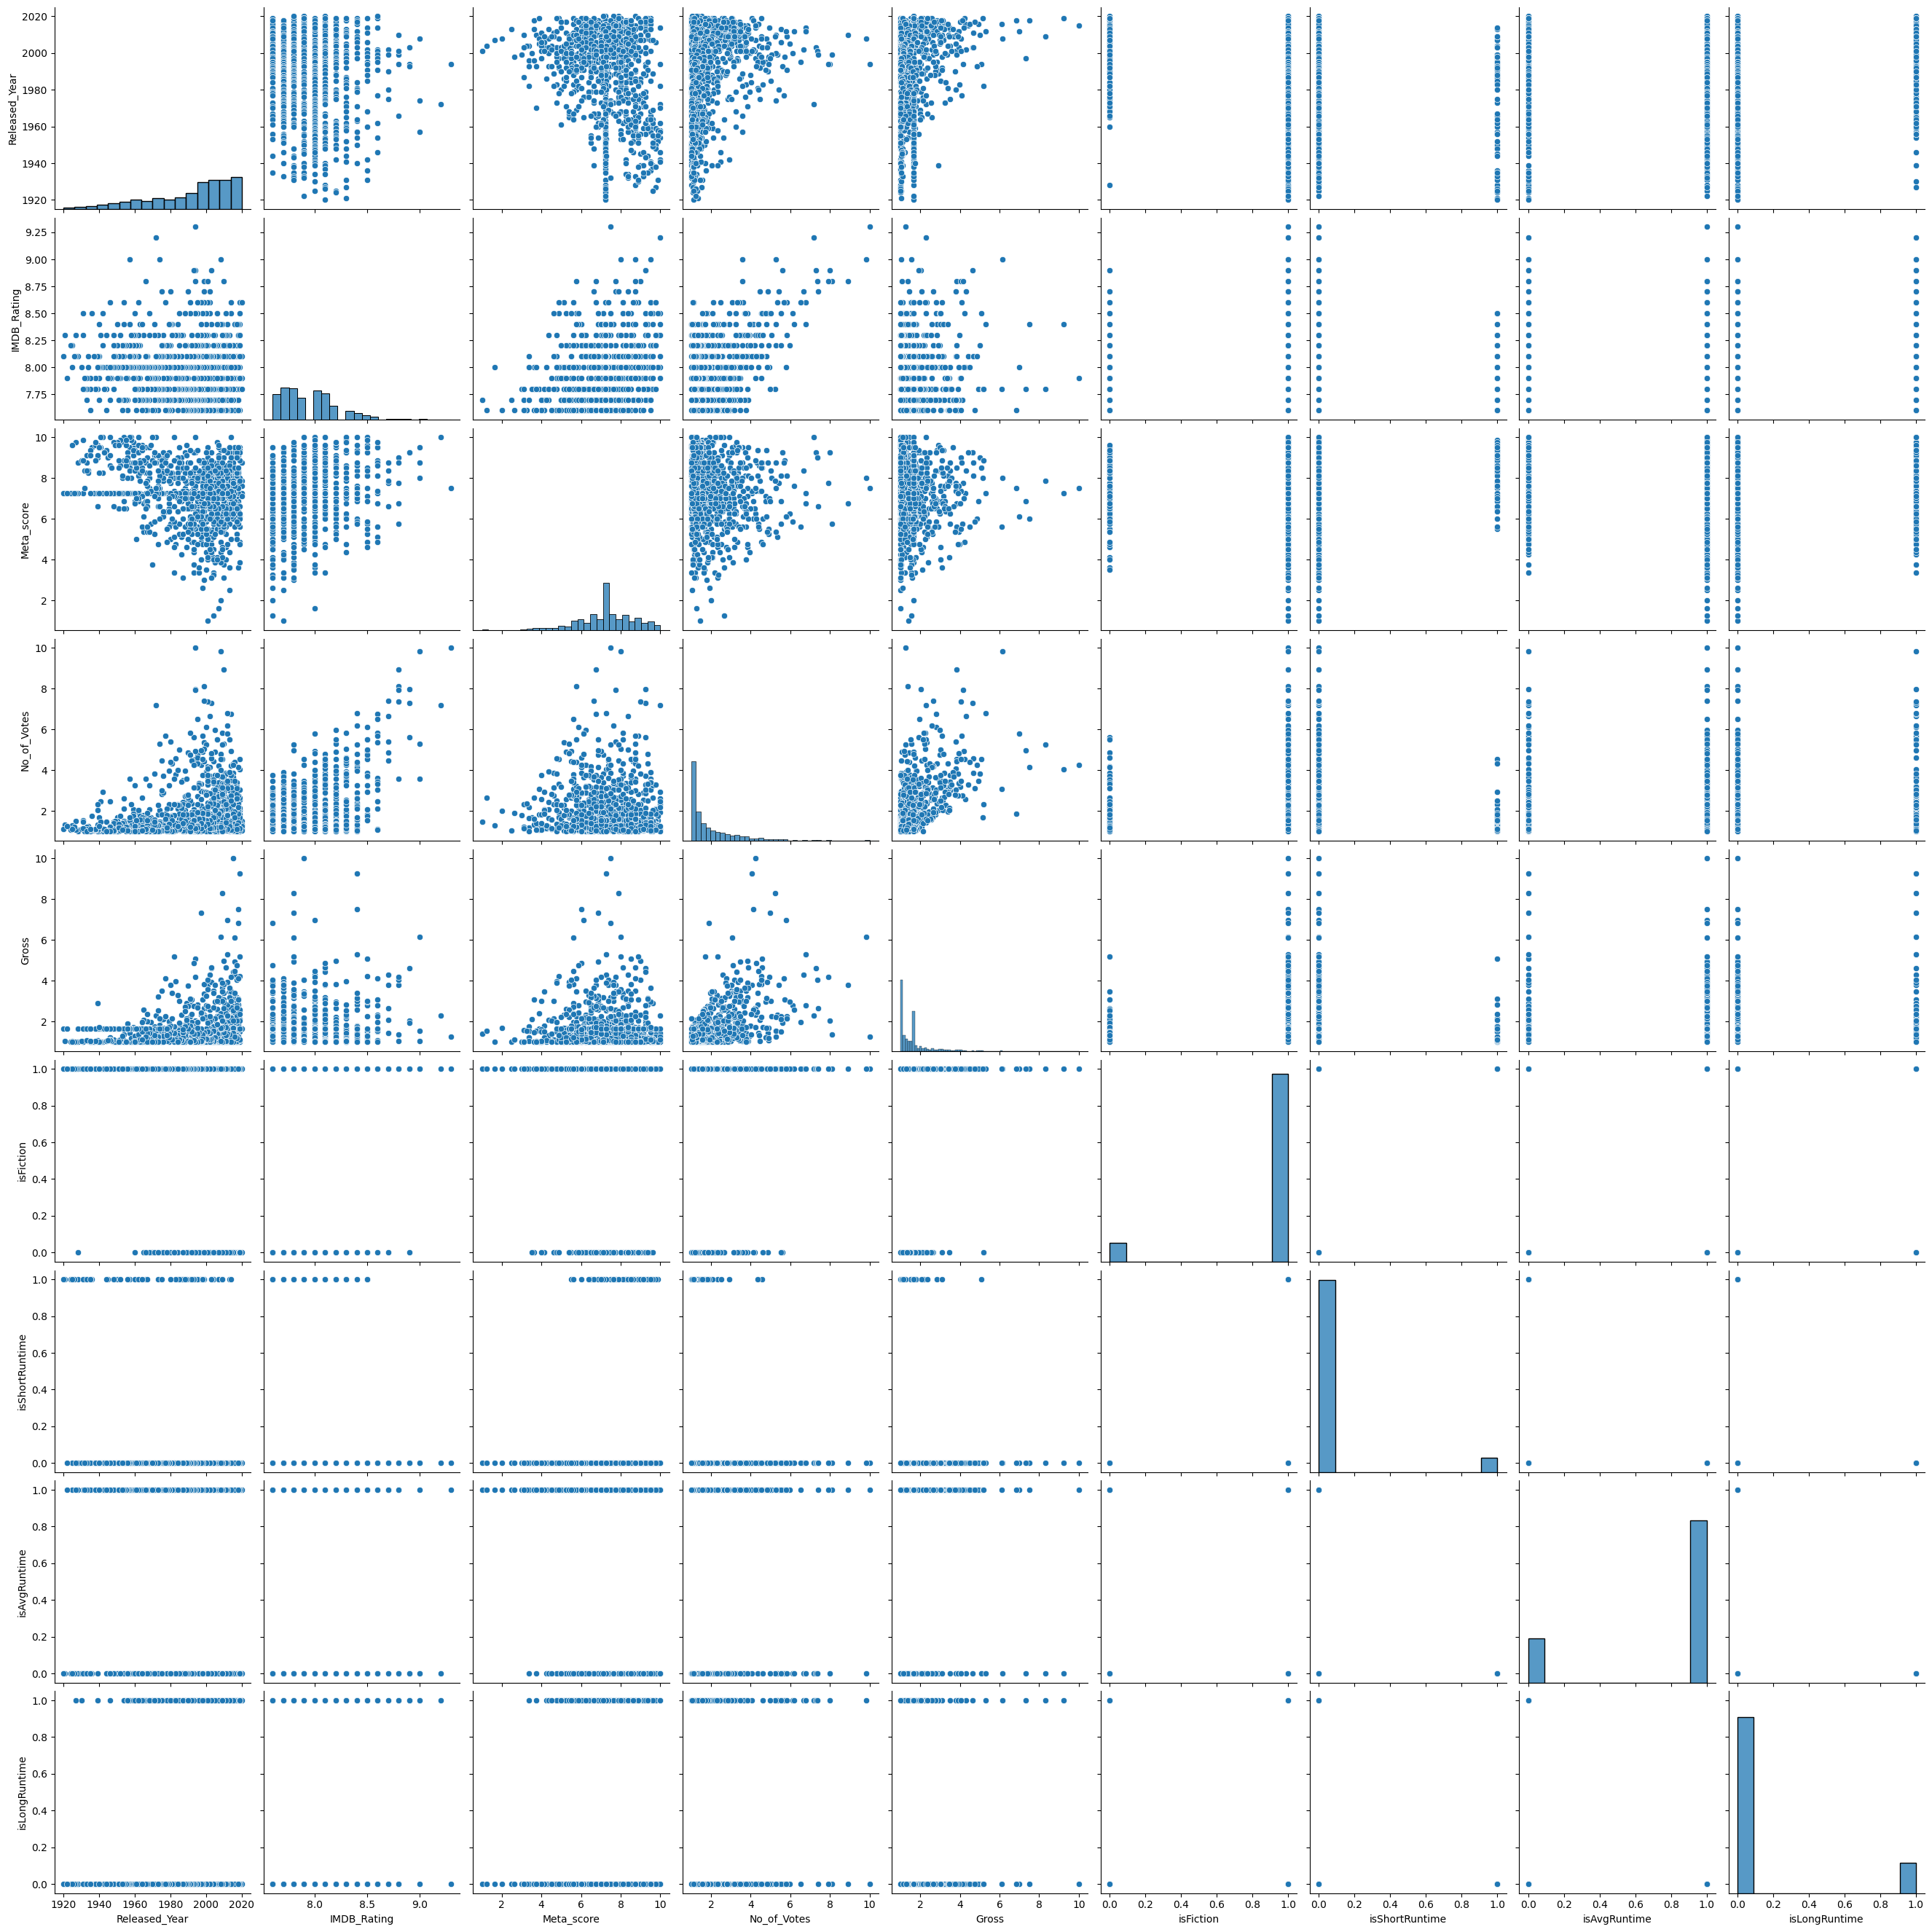

In [ ]:
sns.pairplot(data, height=3)

4. Individual Comparisons with Mean Gross Values

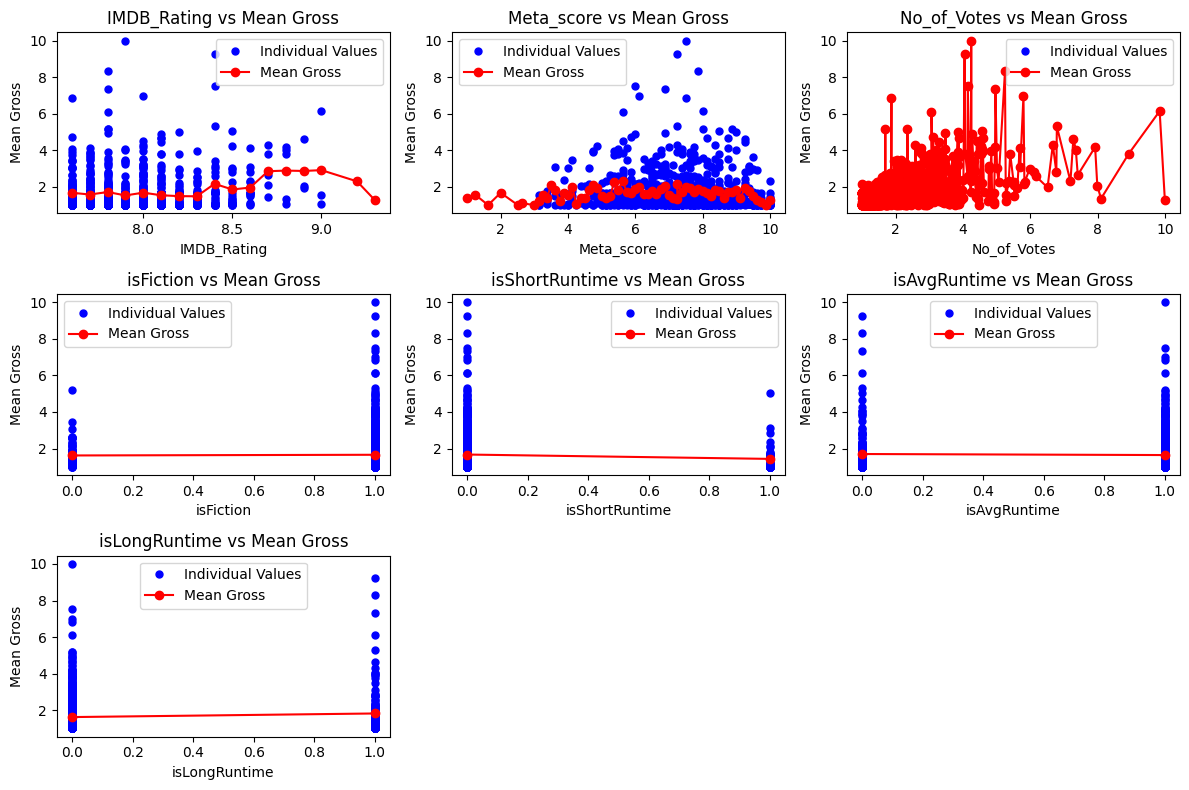

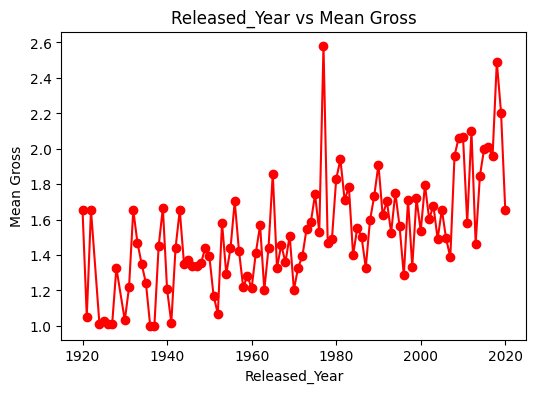

In [ ]:

# Calculate the mean gross value for each Released_Year
mean_gross_by_year = data.groupby(['Released_Year']).agg({'Gross': 'mean'})

# Create line graphs for each feature with the mean of each value of that feature versus the mean gross value
features_to_plot = ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'isFiction', 'isShortRuntime', 'isAvgRuntime', 'isLongRuntime']

plt.figure(figsize=(12, 8))

for feature in features_to_plot:
    plt.subplot(3, 3, features_to_plot.index(feature) + 1)
    plt.plot(data[feature], data['Gross'], marker='o', linestyle='', color='b', markersize=5, label='Individual Values')
    plt.plot(data.groupby([feature])['Gross'].mean(), marker='o', linestyle='-', color='r', label='Mean Gross')
    plt.title(f'{feature} vs Mean Gross')
    plt.xlabel(feature)
    plt.ylabel('Mean Gross')
    plt.legend()

plt.tight_layout()
plt.show()

# Create a line graph for Released_Year versus the mean gross value
plt.figure(figsize=(6, 4))
plt.plot(mean_gross_by_year.index, mean_gross_by_year['Gross'], marker='o', linestyle='-', color='r')
plt.title('Released_Year vs Mean Gross')
plt.xlabel('Released_Year')
plt.ylabel('Mean Gross')
plt.show()

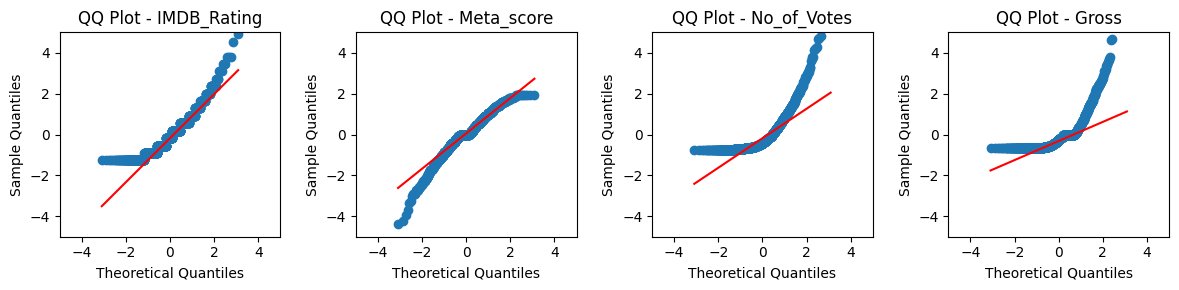

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing numerical columns
columns_to_plot = ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']
selected_data = data[columns_to_plot]

# Drop rows with missing values
selected_data = selected_data.dropna()

# Function to plot QQ plots for each column
def plot_qq_plots(data):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))  # Create a 1x4 grid of subplots

    for i, col in enumerate(data.columns):
        sm.qqplot(data[col], line='q', ax=axes[i], fit=True)
        axes[i].set_title(f'QQ Plot - {col}')

        # Customize y-axis and x-axis limits for a broader range
        axes[i].set_ylim(-5, 5)  # Set y-axis limits
        axes[i].set_xlim(-5, 5)

    plt.tight_layout()
    plt.show()

# Plot QQ plots
plot_qq_plots(selected_data)


### Result of EDA
  - I've used 3 methods, Heatmap, pairplots and a line graphs to measure the highest collinearity features. The rest of the features have little to none correlation.
  - Only IMDB_rating and No_of_Votes happen to have to 0.49 ~.50 correlation value and the graph shown right above shows the trendline which proves that they have correlated.
  -  No_of_Votes and Gross seem to have a lot more outliers comapred to rest of the data based on the bar plots
  - 1. **IMDB rating:** The graph indicates right-skewed data.
    2. **Meta_Score:** The distribution appears to be normal.
    3. **No_Of_Votes:** The graph suggests right-skewed data.
    4. **Gross:** The distribution of Gross appears to be right-skewed.

## How to Handle Missing Values : Data Imputation Techniques

In any ML modeling task, one of the very important task is to check if we have any missing values in our dataset. If there are missing values in the dataset it can horribly change the results and make our model inefficient.
But there are ways to tackle this problem, we will discuss these methods in a bit detail below

- Delete rows with missing data
- Fill the missing data points by either mean/median/random
- Find the % error on residuals as well as bias and variance

Our dataset doesn't have any missing values, lets deliberately create some missing values and have a comparative analysis of how effectively each method is recovering the data back.

We will remove 1%, 5% and 10% of the data from No_Of_Votes ( Most Correlated to Gross)  in our dataset and see how well imputation will recover the data back

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Assuming 'data' is your original DataFrame
data_copy = data.copy()  # Take a copy to preserve the original data

def remove_randomly(df, percentage):
    np.random.seed(0)  # For reproducibility
    mask = np.random.rand(*df.shape) < percentage
    df_removed = df.mask(mask)
    return df_removed

def random_impute(series):
    non_missing = series.dropna()
    imputed_values = non_missing.sample(n=series.isna().sum(), replace=True).values
    series[series.isna()] = imputed_values
    return series

def constant_value_impute(series, value):
    return series.fillna(value)

def impute_evaluate_numeric(df_original, df_removed, strategy):
    if strategy == 'random':
        df_imputed = df_removed.copy()
        df_imputed = random_impute(df_imputed)
    else:
        imputer = SimpleImputer(strategy=strategy)
        df_imputed = pd.DataFrame(imputer.fit_transform(df_removed.values.reshape(-1, 1)), columns=[df_removed.name])

    errors = df_original - df_imputed.squeeze()
    bias = errors.mean()
    variance = errors.var()
    total_error = errors.abs().sum() / df_original.abs().sum()
    print(f"Using {strategy} imputation for {df_removed.name}:")
    print(f"Total percentage error: {total_error*100:.2f}%")
    print(f"Bias (Mean Error): {bias:.4f}")
    print(f"Variance of Error: {variance:.4f}\n")

# Remove 1%, 5%, and 10% of the data randomly and impute 'No_of_Votes'
for percentage in [0.01, 0.05, 0.1]:
    df_removed = remove_randomly(data_copy[['No_of_Votes']], percentage)
    print(f"\nAfter removing {percentage*100}% of data:")

    for strategy in ['mean', 'median', 'random']:
        impute_evaluate_numeric(data_copy['No_of_Votes'], df_removed['No_of_Votes'], strategy)



After removing 1.0% of data:
Using mean imputation for No_of_Votes:
Total percentage error: 0.32%
Bias (Mean Error): -0.0004
Variance of Error: 0.0081

Using median imputation for No_of_Votes:
Total percentage error: 0.25%
Bias (Mean Error): 0.0032
Variance of Error: 0.0095

Using random imputation for No_of_Votes:
Total percentage error: 0.42%
Bias (Mean Error): -0.0020
Variance of Error: 0.0259


After removing 5.0% of data:
Using mean imputation for No_of_Votes:
Total percentage error: 2.01%
Bias (Mean Error): 0.0013
Variance of Error: 0.0562

Using median imputation for No_of_Votes:
Total percentage error: 1.83%
Bias (Mean Error): 0.0258
Variance of Error: 0.0703

Using random imputation for No_of_Votes:
Total percentage error: 2.20%
Bias (Mean Error): 0.0096
Variance of Error: 0.0829


After removing 10.0% of data:
Using mean imputation for No_of_Votes:
Total percentage error: 4.66%
Bias (Mean Error): 0.0014
Variance of Error: 0.1507

Using median imputation for No_of_Votes:
Tota

### Result of Imputation Methods

1. **Impact of Missing Data Percentage**: As the percentage of removed data increases from 1.0% to 10.0%, the total percentage error increases for both mean and median imputation strategies. This is expected, as imputation becomes less accurate with more missing data.

2. **Comparison of Imputation Strategies**:
   - Median imputation consistently results in lower total percentage error compared to mean imputation across all percentages of missing data.
   - This indicates that median imputation provides a more accurate estimation of missing values in the 'No_of_Votes' column in this scenario.
   - Median imputation tends to have a lower bias and variance of error compared to mean imputation, leading to more accurate and stable imputed values.

3. **Effectiveness of Imputation Strategies**: Overall, median imputation appears to be the better choice for imputing missing values in the 'No_of_Votes' column based on the lower total percentage error observed in the results. Median imputation is particularly advantageous when dealing with skewed distributions or when the data contains outliers, as it is less sensitive to extreme values compared to mean imputation.


## End of EDA


---

## Feature Importance and Selection


### 1. OLS Regression

In [ ]:
import statsmodels.api as sm
# Add a constant term for the intercept
data = sm.add_constant(data)
# Define the dependent variable (target)
y = data['Gross']
# Define the independent variables (features)
X = data[['const', 'Released_Year', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'isFiction', 'isShortRuntime', 'isAvgRuntime', 'isLongRuntime']]
# Fit the OLS model
model = sm.OLS(y, X).fit()
# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Gross   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     76.73
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           7.54e-89
Time:                        00:02:50   Log-Likelihood:                -1162.5
No. Observations:                1000   AIC:                             2341.
Df Residuals:                     992   BIC:                             2380.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3420      2.045      2.

### Results of OLS:

1. **Released_Year**: p = 0.759, Not significant.
2. **IMDB_Rating**: p = 0.000, Highly significant.
3. **Meta_score**: p = 0.075, Somewhat significant.
4. **No_of_Votes**: p = 0.000, Highly significant.
5. **isFiction**: p = 0.513, Not significant.
6. **isShortRuntime**: p = 0.010, Significant.
7. **isAvgRuntime**: p = 0.012, Significant.
8. **isLongRuntime**: p = 0.007, Significant.

**Summary**:
- **Highly Significant**: "IMDB_Rating" and "No_of_Votes."
- **Moderately Significant**: "Meta_score," "isShortRuntime," "isAvgRuntime," and "isLongRuntime."
- **Not Significant**: "Released_Year" and "isFiction."

### 2. Check for Multicollinearity using VIF

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

predictors = data[['Released_Year', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'isFiction', 'isShortRuntime', 'isAvgRuntime', 'isLongRuntime']]

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range (len(predictors.columns))]

print(vif_data)


          Feature          VIF
0   Released_Year     1.270918
1     IMDB_Rating     1.608051
2      Meta_score     1.163765
3     No_of_Votes     1.532808
4       isFiction     1.017435
5  isShortRuntime   831.577815
6    isAvgRuntime  9679.429569
7   isLongRuntime  1824.336165


### Results of VIF

1. **Released_Year, IMDB_Rating, Meta_score, No_of_Votes, isFiction**: These variables exhibit VIF values close to 1, indicating low multicollinearity. They are relatively independent of each other and do not suffer from severe multicollinearity issues.

2. **isShortRuntime, isAvgRuntime, isLongRuntime**: These variables have significantly higher VIF values, but these values are conceptually independent.

###What is VIF?


VIF (Variance Inflation Factor) is a measure utilized in regression analysis to assess the severity of multicollinearity among predictor variables. Multicollinearity arises when two or more predictors in a regression model are highly correlated.

- A VIF of 1 indicates no multicollinearity.
- VIF values between 1 and 5 imply moderate multicollinearity, which might not pose significant issues depending on the context.
- VIF values exceeding 5 or 10 indicate severe multicollinearity, leading to unreliable estimates of regression coefficients and inflated standard errors.


##Feature Importance Completed


---

## Let's Build the models

First Let's split the data into Training and Test Splits (90, 10)

### 1. Linear Regression

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import statsmodels.api as sm


# Separate features (X) and target variable (y)
X = data.drop(columns=['Gross'])
y = data['Gross']

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model on the training data
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Print the regression coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_lr.coef_
})
print("Regression Coefficients:")
print(coefficients)
print()

# Predict the target variable using the trained model on both train and test sets
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

# Calculate MAE and RMSE for both train and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print()
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)


Regression Coefficients:
          Feature  Coefficient
0           const     0.000000
1   Released_Year     0.000822
2     IMDB_Rating    -1.021913
3      Meta_score     0.042873
4     No_of_Votes     0.490779
5       isFiction     0.063656
6  isShortRuntime     0.001058
7    isAvgRuntime    -0.050767
8   isLongRuntime     0.049709


Train MAE: 0.49554489650489514
Test MAE: 0.50971591952294
Train RMSE: 0.7452557968100056
Test RMSE: 0.886386325307147


- The linear regression model exhibits lower errors on the training dataset, with an MSE of 0.56 and an MAE of 0.50.
- However, when tested on unseen data, the model's performance slightly deteriorates, resulting in an MSE of 0.79 and an MAE of 0.51, indicating some degree of overfitting.
- Despite this, the model maintains relatively consistent performance, with the RMSE for both training and test data being 0.75 and 0.89, respectively.

### 2. Random Forest Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


# Separate features (X) and target variable (y)
X = data.drop(columns=['Gross'])
y = data['Gross']

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Random Forest model on the training data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict the target variable using the trained model on both train and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate MAE and RMSE for both train and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)
print()




Train MAE: 0.16962854024500096
Test MAE: 0.45505071267782976
Train RMSE: 0.2701862434377546
Test RMSE: 0.8023720696553549



- The random forest model seems to perform well, with both MAE and RMSE values indicating reasonable accuracy on both the training and test sets.
- The model demonstrates good generalization ability, as the performance metrics on the test set are comparable to those on the training set.

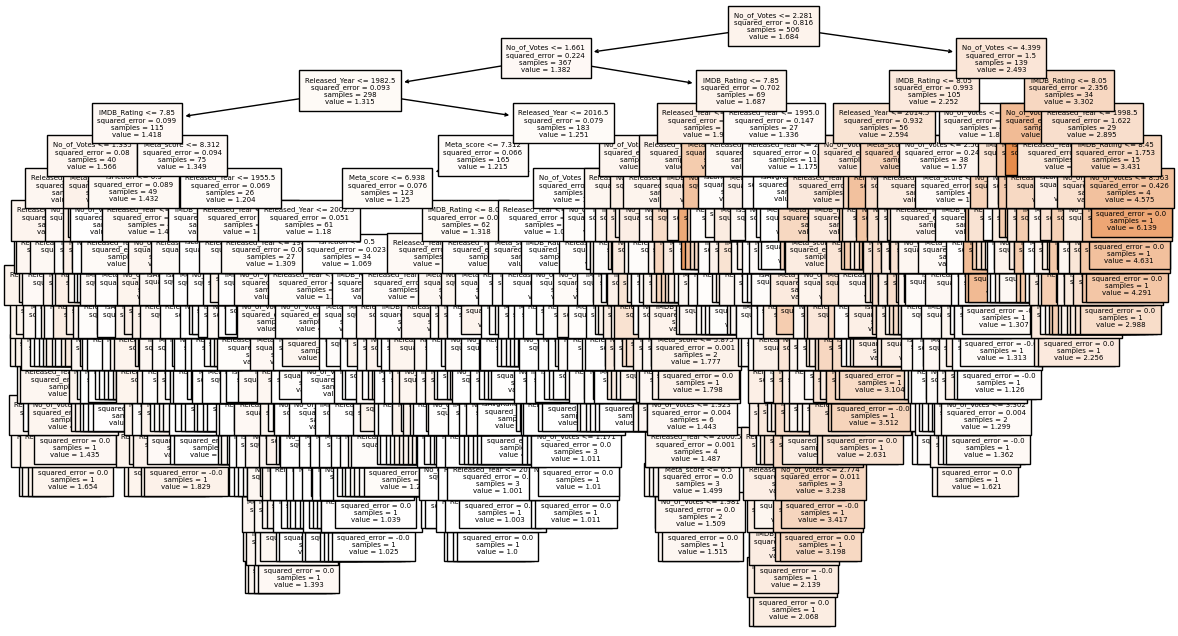

In [53]:
#Let's see what a tree looks like in the random forest model
from sklearn.tree import plot_tree

# Extract one tree from the random forest model (for example, the first tree)
tree = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(14, 8))
plot_tree(tree, feature_names=X.columns, filled=True, fontsize=5)
plt.show()


Observation from the Tree:  
- `No_of_votes` is the root node due to highest significance, followed by `Released_Year` and the `IMDB_rating` and `Meta_Score`
- The diagram is as expected from the feature importance

#### Comparison of Results between the first 2 models

- Overall, the random forest model outperforms the linear regression model based on both MAE and RMSE for both the training and test sets.
- The random forest model shows significantly lower MAE and RMSE values on both the training and test sets, indicating better predictive performance.
- This suggests that the random forest model captures more complex relationships in the data and generalizes better to unseen data compared to the linear regression model.

### 3. AutoML

In [ ]:
!pip install h2o
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

# Initialize H2O cluster
h2o.init()

h2o_df = h2o.H2OFrame(data)

# Identify predictors and response
x = h2o_df.columns
y = "Gross"
x.remove(y)

# Run AutoML, excluding stacked ensemble
aml = H2OAutoML(max_runtime_secs=150, exclude_algos=["StackedEnsemble"])
aml.train(x=x, y=y, training_frame=h2o_df)

# View the AutoML leaderboard
lb = aml.leaderboard
print(lb)

# Get the best model from AutoML
best_model = aml.leader
print(best_model)

# Shutdown H2O cluster
#h2o.shutdown()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.9 MB/s eta 0:00:00
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpk38qmd1j
  JVM stdout: /tmp/tmpk38qmd1j/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpk38qmd1j/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_7y5c9c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
00:04:34.208: _train param, Dropping bad and constant columns: [const]

███
00:04:41.100: _train param, Dropping bad and constant columns: [const]
00:04:42.219: _train param, Dropping bad and constant columns: [const]

██
00:04:46.549: _train param, Dropping bad and constant columns: [const]

███
00:04:52.969: _train param, Dropping bad and constant columns: [const]

██
00:04:57.323: _train param, Dropping bad and constant columns: [const]
00:04:58.704: _train param, Dropping bad and constant columns: [const]

█
00:05:00.135: _train param, Dropping bad and constant columns: [const]

█
00:05:02.221: _train param, Dropping bad and constant columns: [const]

█
00:05:05.696: _train param, Dropping bad and constant columns: [const]

█
00:05:08.949: _train param, Dropping bad and constant columns: [const]

█
00:05:10.29: _train param, Dropping bad and constant columns: [const]

█

### HyperParameter Tuning of AutoML's Best Model

In [ ]:
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

# Define hyperparameters to tune
hyperparameters = {
    'ntrees': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [3, 5, 7],     # Maximum depth of the trees
    'learn_rate': [0.1, 0.01],  # Learning rate
    'sample_rate': [0.8, 0.9]   # Sample rate
}

# Train the GBM model with grid search
gbm_model = H2OGradientBoostingEstimator(seed=42,
                                         stopping_metric='rmse',  # Metric for early stopping
                                         stopping_rounds=3,       # Number of rounds for early stopping
                                         nfolds=5)                # Number of folds for cross-validation
# Perform grid search over the hyperparameters
gbm_grid = H2OGridSearch(model=gbm_model, hyper_params=hyperparameters)

# Train the GBM grid search
gbm_grid.train(x=x, y=y, training_frame=h2o_df)

# Get the best GBM model from the grid search
best_gbm_model = gbm_grid.get_grid()[0]

# View the parameters of the best GBM model
print(best_gbm_model.params)

gbm_perf = best_gbm_model.model_performance(test_data=h2o_df)
print(gbm_perf)


gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'Grid_GBM_Key_Frame__upload_bff91e48e6cc0d08441a4ab16afe44b6.hex_model_python_1712102665993_16_model_19', 'type': 'Key<Model>', 'URL': '/3/Models/Grid_GBM_Key_Frame__upload_bff91e48e6cc0d08441a4ab16afe44b6.hex_model_python_1712102665993_16_model_19'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'Key_Frame__upload_bff91e48e6cc0d08441a4ab16afe44b6.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/Key_Frame__upload_bff91e48e6cc0d08441a4ab16afe44b6.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'Key_Frame__upload_bff91e48e6cc0d08441a4ab16afe44b6.hex', 'type': 'Key<Frame>', 'URL'

### Results of AutoML
- The AutoML model's best model is GBM and the results of model run on the test data are here:

ModelMetricsRegression: gbm model


      - MSE: 0.30794192207326915
      - RMSE: 0.5549251499736421
      - MAE: 0.37859761011600496
      - RMSLE: 0.16076003149356882
      - Mean Residual Deviance: 0.30794192207326915

- The results of the Best model after hyperparameter tuning is shown above.
- I can say that the tuning doesn't help based on the results. Since the MSE and MAE are both higher after tuning.



### The Readable Results of the Models so far


- Based on the provided metrics, the hyperparameter-tuned Gradient Boosting Machine (GBM) model performed the best among the three models. It achieved the lowest MAE, RMSE, and RMSLE on both the cross-validation and test datasets, indicating superior predictive performance.

- GBM models are known for their ability to capture complex relationships in the data through boosting and gradient descent optimization.

- Despite the simplicity and effectiveness of Random Forest models, as well as the potential of AutoML techniques to select the best model automatically, the hyperparameter-tuned GBM model outperformed them due to its capacity to fine-tune model parameters and optimize predictive accuracy.

- This underscores the importance of careful model selection and hyperparameter tuning in achieving optimal performance for regression tasks.


## Building Models Completed



---


## Model Interpretability


### 1. SHAP Analysis

**SHapley Additive exPlanations (SHAP)**, more commonly known as SHAP, is used to explain the output of Machine Learning models. It is based on Shapley values, which use game theory to assign credit for a model’s prediction to each feature or feature value.

The way **SHAP** works is to decompose the output of a model by the sums of the impact of each feature. **SHAP** calculates a value that represents the contribution of each feature to the model outcome. These values can be used to understand the importance of each feature and to explain the result of the model to a human.


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.3 MB/s eta 0:00:00


- For Linear Model

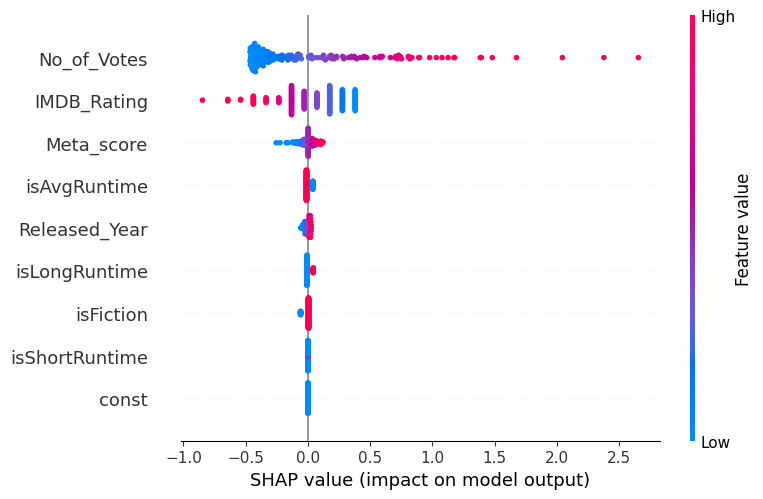

In [ ]:
import shap
# For Linear Regression
# Load linear regression model (already trained)
# model_lr = ...

# Create SHAP explainer
explainer_lr = shap.Explainer(model_lr, X_train)

# Calculate SHAP values
shap_values_lr = explainer_lr.shap_values(X_test)

# Plot SHAP summary plot or other relevant visualizations
shap.summary_plot(shap_values_lr, X_test)
print()


**Interpretation of SHAP Summary Plot for Linear Model:**

1. **Feature Impact:** Each row represents a feature, ranked by significance. The x-axis shows SHAP values, indicating feature impact.

2. **SHAP Value Distribution:** The spread of dots for each feature shows the variability of impact across data points.

3. **Prediction Influence:** Positive SHAP values (right) increase predictions, while negative values (left) decrease them. Color indicates feature value.

4. **Top Features:** 'No_of_Votes' and 'IMDB_Rating' are impactful, with wide spreads and many dots far from the center.

5. **High/Low Values:** Pink dots represent high feature values, while blue dots represent low values, showing their impact on predictions.

This SHAP summary plot provides insights into feature importance and how different values affect predictions, offering a comprehensive view of the model's behavior in an interpretable manner.


- For Random Forest Model

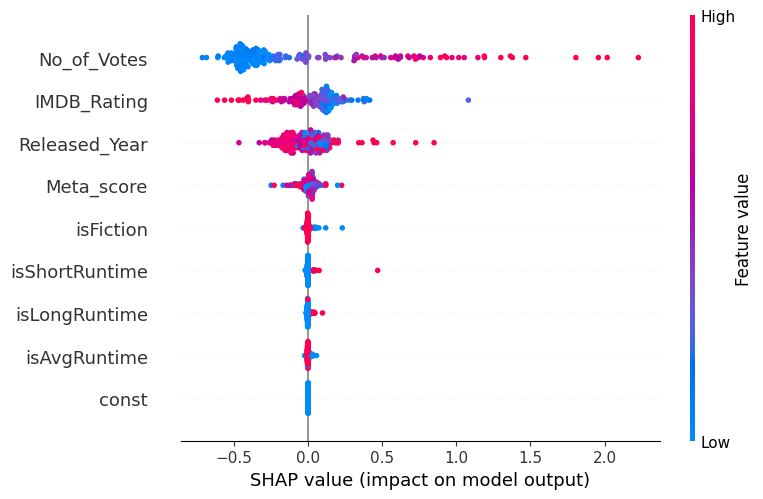

In [ ]:
# SHAP analysis for Random Forest model
# Load random forest model (already trained)
# model_rf = ...

# Create SHAP explainer
explainer_rf = shap.TreeExplainer(rf_model)

# Calculate SHAP values
shap_values_rf = explainer_rf.shap_values(X_test)

# Plot SHAP summary plot or other relevant visualizations
shap.summary_plot(shap_values_rf, X_test)

**Interpretation of SHAP Summary Plot for Random Forest Algorithm:**

- **Feature Ranking:** 'No_of_Votes' and 'IMDB_Rating' are the most influential features, with the strongest impact on the model's output.

- **Feature Impact Direction:**
  - 'No_of_Votes': Higher numbers generally increase predictions significantly.
  - 'IMDB_Rating': Higher ratings mostly contribute positively to predictions.

- **High/Low Feature Values:** Pink (high) and blue (low) indicate the feature value's impact on predictions.

- **Released_Year Impact:** Shows varying but generally smaller impact on predictions.

- **Runtime and Fiction Status:** Binary features have less influence compared to 'No_of_Votes' and 'IMDB_Rating', suggesting they have a relatively low impact on predictions.

**Summary:**
The number of votes and IMDB rating are significant predictors, with higher values typically increasing predictions. Release year and genre have less impact compared to votes and ratings.


contributions progress: |████████████████████████████████████████████████████████| (done) 100%
   Released_Year  IMDB_Rating  Meta_score  No_of_Votes  isFiction  \
0      -0.222498    -0.369170   -0.031592     1.455438   0.003876   
1      -0.125157    -0.301012    0.035656     1.725040   0.003972   
2       0.155132    -0.238730    0.183521     2.056587   0.006066   
3      -0.105290    -0.392249    0.067116     1.275936   0.003972   
4      -0.139486    -0.440992   -0.043810     0.325786   0.004372   

   isShortRuntime  isAvgRuntime  isLongRuntime  BiasTerm  
0               0     -0.020208      -0.000828  1.652598  
1               0      0.167020       0.007063  1.652598  
2               0      0.206093       0.007063  1.652598  
3               0      0.167020       0.007063  1.652598  
4               0     -0.027211      -0.002134  1.652598  


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


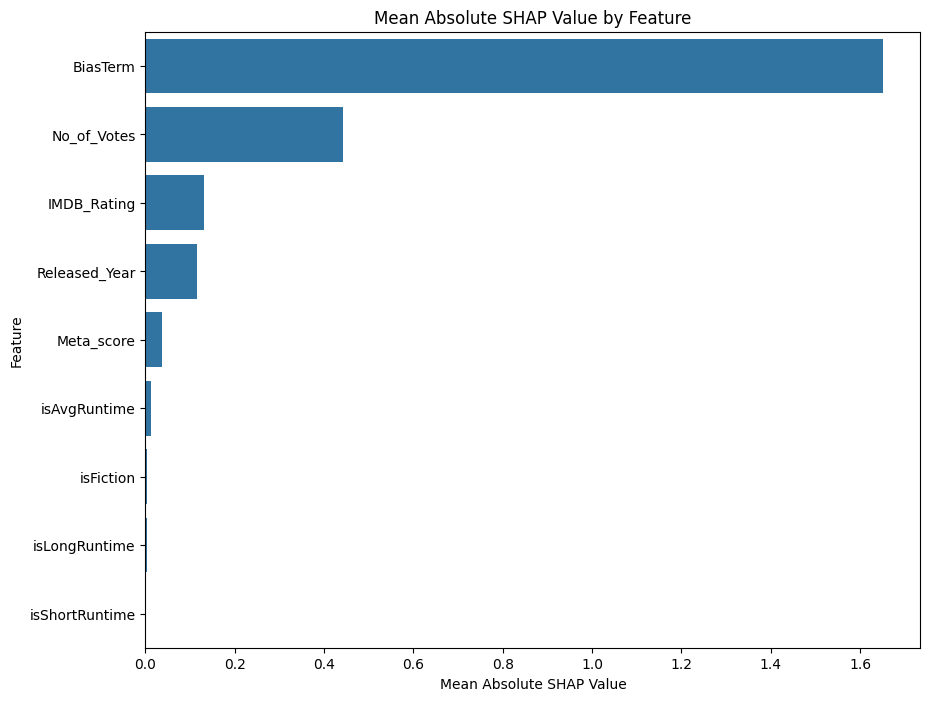

In [ ]:
# SHAP Analysis for AutoML
# Generate SHAP values (feature contributions) for your model
shap_values = best_model.predict_contributions(h2o_df)

# Convert SHAP values H2OFrame to a Pandas DataFrame for easier manipulation and visualization
shap_values_df = shap_values.as_data_frame()

# Now, shap_values_df contains the SHAP values for each feature for each sample in h2o_df.
# You can use these SHAP values for custom visualization or analysis.

# Example: Displaying the first few rows of the SHAP values DataFrame
print(shap_values_df.head())

!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `shap_values_df` is your DataFrame containing the SHAP values for each feature

# Calculate the mean absolute SHAP values for each feature
shap_summary = shap_values_df.abs().mean().sort_values(ascending=False)

# Reset index to get feature names as a column
shap_summary = shap_summary.reset_index()
shap_summary.columns = ['Feature', 'MeanAbsSHAP']

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x="MeanAbsSHAP", y="Feature", data=shap_summary)
plt.title('Mean Absolute SHAP Value by Feature')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.show()

### 2. LIME Analysis

- LIME (Local Interpretable Model-agnostic Explanations) is a technique used to explain individual predictions of complex machine learning models in an interpretable and understandable manner.
- It works by approximating the model locally with an interpretable one (like a linear model or decision tree), using the local prediction behavior around a particular instance.
- By perturbing the input data and observing the corresponding changes in the output, LIME identifies which features significantly influence the prediction for a single data point. The explanations provided by LIME are local, meaning they are specific to individual predictions rather than the model's overall behavior.

- For Linear Model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=24aa911a0f3d30481d75abbc39f6f4c8564cf65b2ce49eabd7aca793620b03bf
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


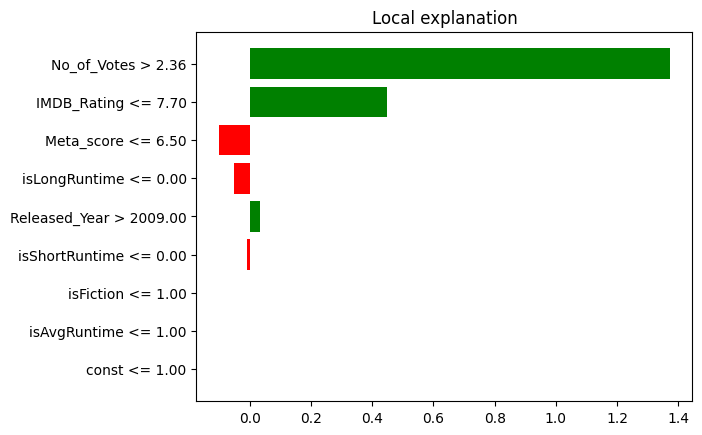

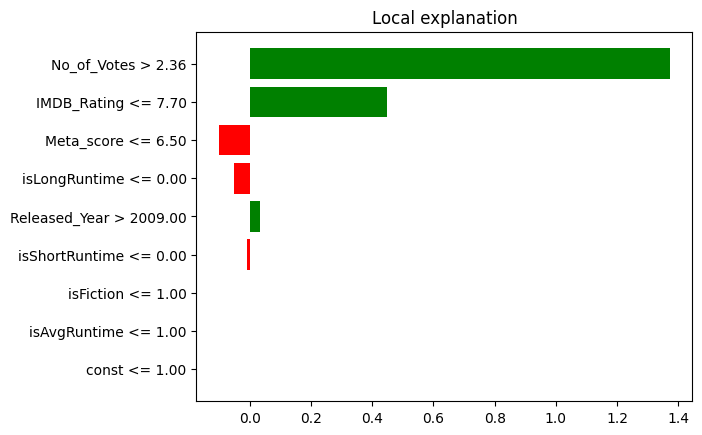

In [ ]:
!pip install lime

from lime import lime_tabular

# Instantiate the LimeTabularExplainer
# Note: If your feature data (X) is a DataFrame, ensure to convert it to a numpy array using X.values
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    class_names=['Gross'],
    mode='regression'
)

# Choose an instance to explain
instance_index = 2 # You can change this index to any instance you want to explain

# Explain the prediction of this instance
exp = explainer.explain_instance(
    data_row=X_test.values[instance_index],
    predict_fn=model_lr.predict,
    num_features=len(X.columns) # You can adjust this to limit the number of features to include in the explanation
)

# Visualize the explanation
# exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()


**Interpretation of Lime analysis on Linear Model**

- A high number of votes (No_of_Votes > 2.36) seems to have a strong positive impact on the target variable 'Gross', pushing it to be higher.
- A lower IMDb rating (IMDB_Rating <= 7.70) seems to decrease the target variable 'Gross'.
- The feature Meta_score <= 6.50 appears to also decrease the target variable, as indicated by the red bar.
- Other features such as isLongRuntime, Released_Year, and isShortRuntime have varying impacts, some positive and some negative, on the prediction.

- For Random Forest Model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


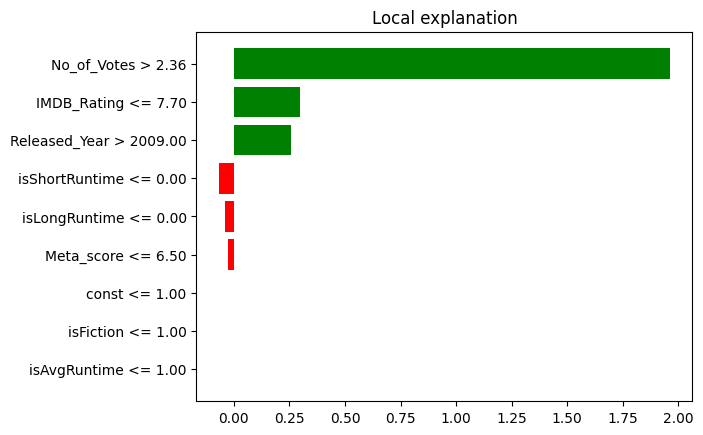

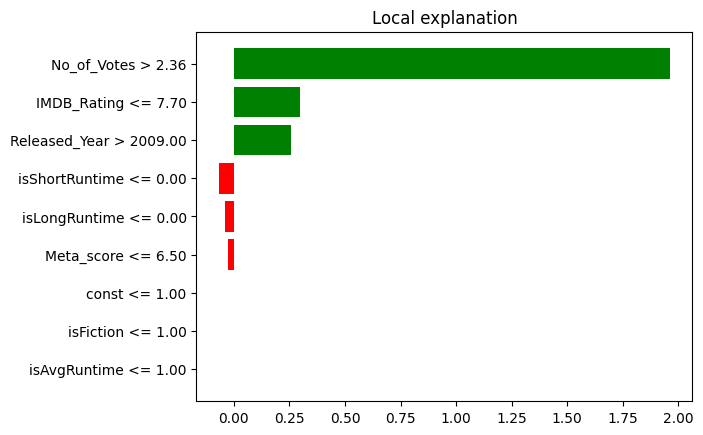

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize a LIME Tabular Explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Gross'],
    mode='regression'
)

# Select an instance to explain. Here we select the second data point (index 1) from the test set.
instance_index = 1

# Explain the prediction made by the random forest model
exp = explainer.explain_instance(
    data_row=X_test.values[instance_index],
    predict_fn=rf_model.predict,
    num_features=len(X_train.columns)
)

# Visualize the explanation
# If you're using Jupyter Notebook, use the following:
# exp.show_in_notebook(show_table=True)

# If you're not in a Jupyter environment, use the following:
exp.as_pyplot_figure()
# plt.show()


**Interpretation of Lime Analysis for Random Forest Model**

- **No_of_Votes:** Greater than 2.36 has the largest positive impact on predictions, making it the most influential feature.
  
- **Released_Year:** A release year greater than 2009 positively influences predictions, but less than No_of_Votes.
  
- **IMDB_Rating:** Ratings 7.70 or lower contribute negatively to predictions, indicating lower ratings decrease the predicted value.
  
- **isShortRuntime:** Movies with a short runtime tend to decrease predicted value.
  
- **isLongRuntime:** Similar to isShortRuntime, movies without a long runtime may decrease predicted value.
  
- **Meta_score:** Scores 6.50 or lower have a small negative impact on predictions.
  
- **isFiction and isAvgRuntime:** These features have negligible impact on predictions.


- For AutoML

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


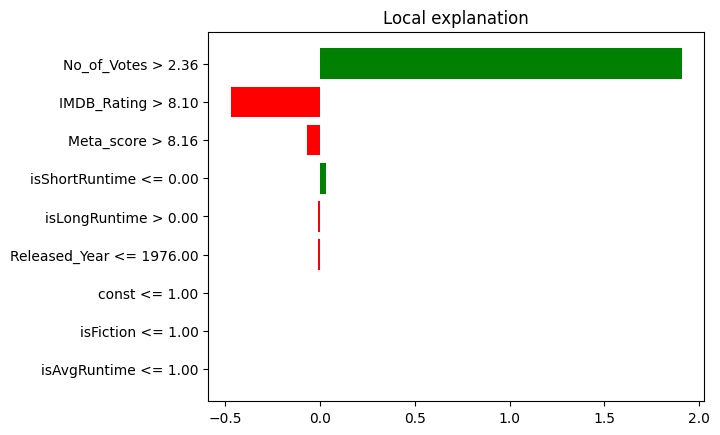

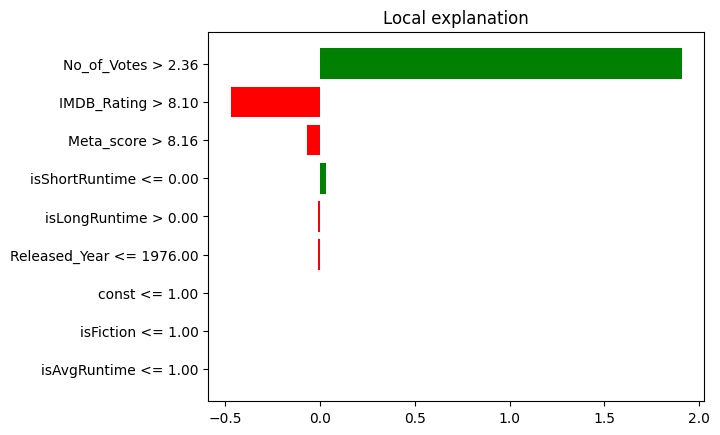

In [ ]:
import h2o
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer

df = data

# Define the name of the target variable
y = "Gross"

# Define a function to make predictions using the H2O leader model
def predict_fn(X):
    if isinstance(X, pd.DataFrame):  # If X is a DataFrame, convert it to an H2OFrame
        h2o_df = h2o.H2OFrame(X)
    else:  # If X is a numpy array, convert it accordingly
        h2o_df = h2o.H2OFrame(pd.DataFrame(X, columns=df.drop(columns=[y]).columns))
    preds = best_model.predict(h2o_df)
    return preds.as_data_frame().values

# Initialize a LIME Tabular Explainer
explainer = LimeTabularExplainer(
    training_data=df.drop(columns=[y]).values,
    feature_names=df.drop(columns=[y]).columns,
    mode='regression'
)

# Select an instance to explain, using its index from the test set
# You should create a test set beforehand if you haven't done so
instance_index = 1
instance = df.drop(columns=[y]).iloc[instance_index].astype(float)

# Explain the prediction made by the H2O model
exp = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=predict_fn,
    num_features=len(df.drop(columns=[y]).columns)
)

# Visualize the explanation (works in Jupyter Notebook)
#exp.show_in_notebook(show_table=True)

# If not in Jupyter, convert the explanation to a pyplot figure and show it
exp.as_pyplot_figure()
# plt.show()


**Interpretation of Lime Analysis on the top AutoML Model**

- **No_of_Votes:** Values > 2.36 have strong negative impact in 1st graph, strong positive in 2nd, suggesting differing effects on predictions.

- **IMDB_Rating:** Values > 8.10 negatively impact predictions in both graphs, indicating higher ratings decrease predictions.

- **isLongRuntime:** Values > 0 (likely indicating long runtime) moderately positively impact predictions in both graphs.

- **Released_Year:** Values <= 1976 negatively impact predictions in both graphs, implying older movies predict lower target values.

- **isShortRuntime:** No significant impact visible in graphs, suggesting minimal effect on predictions.

- **Meta_score:** Values > 8.16 positively impact predictions in both graphs, suggesting higher meta-scores increase predictions.

- **isAvgRuntime and isFiction:** Values <= 1 (indicating average runtime or non-fictional) show no significant impact on predictions in both graphs.


-  For Tuned GBM Model

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


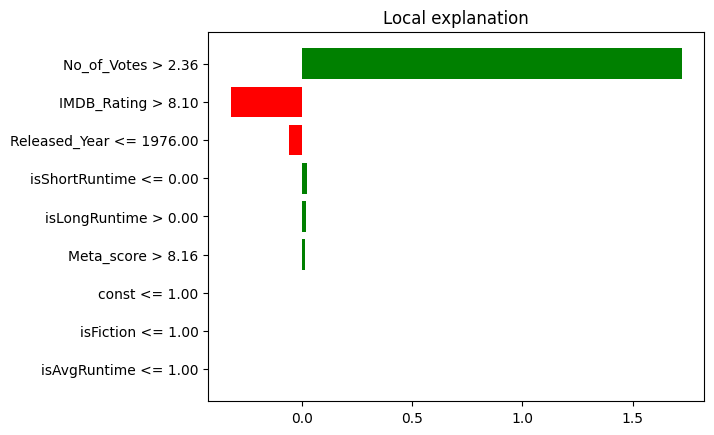

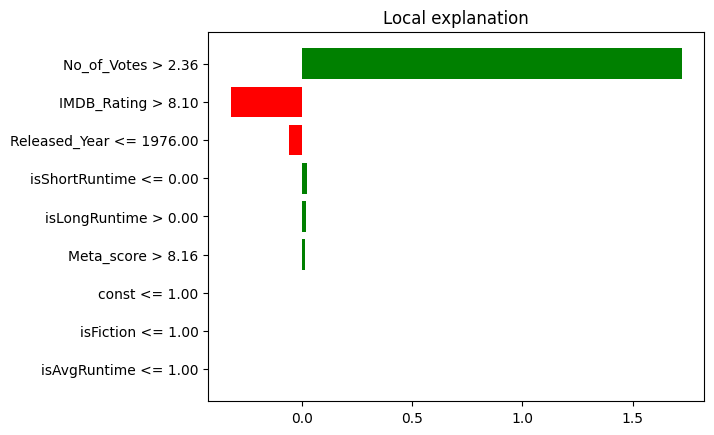

In [ ]:
import h2o
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer

# Convert the H2OFrame to a pandas DataFrame for LIME
df = data

# Define the name of the target variable
y = "Gross"

# Define a function to make predictions using the H2O model
def predict_fn(X):
    if isinstance(X, pd.DataFrame):  # If X is a DataFrame, convert it to an H2OFrame
        h2o_df = h2o.H2OFrame(X)
    else:  # If X is a numpy array, convert it accordingly
        h2o_df = h2o.H2OFrame(pd.DataFrame(X, columns=df.drop(columns=[y]).columns))
    preds = best_gbm_model.predict(h2o_df)
    return preds.as_data_frame().values

# Initialize a LIME Tabular Explainer
explainer = LimeTabularExplainer(
    training_data=df.drop(columns=[y]).values,
    feature_names=df.drop(columns=[y]).columns,
    mode='regression'
)

# Select an instance to explain, using its index from the test set
# You should create a test set beforehand if you haven't done so
instance_index = 1
instance = df.drop(columns=[y]).iloc[instance_index].astype(float)

# Explain the prediction made by the H2O model
exp = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=predict_fn,
    num_features=len(df.drop(columns=[y]).columns)
)

# Visualize the explanation (works in Jupyter Notebook)
# exp.show_in_notebook(show_table=True)

# If not in Jupyter, convert the explanation to a pyplot figure and show it
exp.as_pyplot_figure()
# plt.show()


**Interpretation of Lime Analysis on the top AutoML Model**

- **No_of_Votes:** Values > 2.36 have strong negative impact in 1st graph, strong positive in 2nd, suggesting differing effects on predictions.

- **IMDB_Rating:** Values > 8.10 positively impact predictions in both graphs, indicating higher ratings increase predictions.

- **isLongRuntime:** Values > 0 (likely indicating long runtime) moderately positively impact predictions in both graphs.

- **Released_Year:** Values <= 1976 negatively impact predictions in both graphs, implying older movies predict lower target values.

- **isShortRuntime:** No significant impact visible in graphs, suggesting minimal effect on predictions.

- **Meta_score:** Values > 8.16 positively impact predictions in both graphs, suggesting higher meta-scores increase predictions.

- **isAvgRuntime and isFiction:** Values <= 1 (indicating average runtime or non-fictional) show no significant impact on predictions in both graphs.


### **Results of Model Interpretability**

- As observed, `No_of_Votes` has the highest effect on the target, this is seen in both SHAP and LIME analysis
- There is no effect on the target variable from the `isFiction` and `Avg_runtime` features
- The year the movie is released, conceptually cannot be used as a prediction as there are many variables which may affect what happens in that year.
- The only features that show variation are `IMDB_rating` and `Meta_Score`. In all of the analysis plots IMDB_rating has had a postive relation with the target where as Meta_Score changes slightly in the Tuned GBM model. Although a minute change, it may be of a bigger affect is a bigger dataset is available
- That change is worth pursuing

## Model Interpretability Completed



---

## Questions and Conclusion


##Questions to be Answered:

Q1. What is the question?
   
  -  Here the question to complete a Machine Learning report to predict Gross Income for a movie based on the top 1000 movie dataset using Data Cleaning, Feature Selection, Modeling, and Interpretability.

Q2. What did you do?
  
  - I loaded the data from the top 1000 movies dataset
  - I cleaned the data, encoded categorical variables, removed features based on conceptual information and normalised the data to match other features
  - I ran some plots on the cleaned data for Exploratory Data analysis using Heatmaps, pair plots and box plots to see relations and feature dependencies
  - I then checked for multicollinearity and predictor significance using VIF and OLS
  - I then built my models on my data, I ran my data through a linear regression mode, Random forest model, autoML and a hyper parameter tuned top model of autoML and compared their results
  - I then ran these models through SHAP and LIME model interpretability methods and summarised my readings of these models

Q3. How well did it work?
- Considering my dataset, the prediction accuracy is not that high, due to the fact that one feature dominates the prediction, which is `No_of_votes`.
- My best model was the hyper parameter tuned GBM model that I got after AutoML.
- If more data were to be present and more features, this prediction would start to make more sense

Q4. What did you learn?
-  I learnt how to do a complete analysis on my Dataset.
- I learnt how to clean data, how to think while trying to clean the data
- I learnt how to choose models, how to figure out which model does better that the other
- I learnt how to see which feature is best predicting my target
- I learnt how to create a precise report for my learnings
- I also learnt why a dataset needs to be big enough for me to learn from it.

# Conclusion

In conclusion, this report meticulously cleaned and processed a dataset of the top 1000 IMDb movies, aiming to identify key factors driving movie success. Through rigorous analysis and the use of predictive models, significant features influencing movie rankings were uncovered. Employing advanced interpretability techniques enhanced our understanding of these factors, providing valuable insights for decision-making in the entertainment industry. Overall, this holistic approach offers actionable insights into the complex dynamics of movie success, guiding future strategies for production and marketing in the film industry


# References

1. Sckit learn offcial documentation
2. Refered Towards Data Science
1. Chatgpt
2. Kaggle
3. Youtube
4. Analytics Vidhya
5. https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/Model_Interpretability/SHAP%20and%20LIME%20analysis%20Walkthrough.ipynb
6. https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/Full_ML_Report/Wine-Quality-Analysis.ipynb


The algorithms were referred directly from the Sckit learn official documentation. Visualization was referred from the Machine Learning with scikit-learn Quick Start Guide and Towards Data Science (How do you check the quality of your regression model in Python?). The remaining code was written independently and with help of chatGPT . Feature importance reference is taken from eli5 offical documnetation

# Licensing

MIT License

Copyright (c) 2024 KaushikMreddy

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.